# <center>Analyze score distribution</center>

This notebook contains the code to:
- Normalize scores
- Getting plots for the score distributionPrediction

In [1]:
import os
import sys

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sys.path.append('../')
from src import analysis
from src.full_pipeline import normalize_ensemble_df

PLOTS_PATH = '../data/plots'
PREDICTIONS_PATH = '../data/predictions'

mpl.rcParams['figure.dpi'] = 360
sns.set_style('whitegrid')

## Load predictions

In [2]:
df = pd.read_csv(os.path.join(PREDICTIONS_PATH, 'all_predictions.csv'), sep='\t')

## Normalize and filter Scores

- BioKG: 99%
- OpenBiolink: 95%

In [3]:
df_test = df[df['dataset'] == 'test'].copy().reset_index()
df_norm = normalize_ensemble_df(df_test)

In [4]:
FILTER_BIOKG = 0.99
FILTER_OPENBIOLINK = 0.95

df_biokg = normalize_ensemble_df(df_test[df_test['kg'] == 'biokg'], norm_topk=FILTER_BIOKG)
df_openbio = normalize_ensemble_df(df_test[df_test['kg'] == 'openbiolink'], norm_topk=FILTER_OPENBIOLINK)
df_norm_filter = pd.concat([df_biokg, df_openbio], ignore_index=True)

## Plot Score distribution

### Auxiliary functions

In [5]:
kg2title = {
    'openbiolink': 'OpenBioLink',
    'biokg': 'BioKG',
}

model2title = {
    'rescal': 'RESCAL',
    'transe': 'TransE',
    'distmult': 'DistMult',
    'ermlp': 'ERMLP',
    'transh': 'TransH',
    'complex': 'ComplEx',
    'hole': 'HolE',
    'conve': 'ConvE',
    'rotate': 'RotatE',
    'mure': 'MuRE',   
}


def create_legend(models, palette):
    patches = []
    for model, color in zip(models, palette):
        patch = mpatches.Patch(color=color, label=model2title[model])
        patches.append(patch)
    return patches
    

def plot_score_distribution(
    df,
    bins=None,
    xlim=None,
    ylim=None,
    title=None,
    nrows=2,
    ncols=1,
    figsize=(22,18),
    save_to=None
):

    models = df.model.unique()
    palette = sns.color_palette('hls', n_colors=len(models))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    _bins = 'auto'
    for i, (ax, kg) in enumerate(zip(axs, df.kg.unique())):
        if bins is not None:
            _bins = bins[i]
        sns.histplot(
            data=df[(df['kg'] == kg) & df['model'].isin(models)],
            x='score',
            hue='model',
            hue_order=models,
            palette=palette,
            ax=ax,
            legend=False,
            bins=_bins,
        )
        ax.set_title(kg2title[kg], y=1.0, pad=-20, fontsize=20)
        if xlim is not None:
            ax.set_xlim(xlim[i])
        if ylim is not None:
            ax.set_ylim(ylim[i])
        ax.set_xlabel('Score', fontsize=16)
        ax.set_ylabel('Count', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=14)  
    
    bars = [r for r in axs[1].get_children() if type(r) == mpatches.Rectangle]
    colors = [c.get_facecolor() for c in bars[:-1]]
    colors = set(colors)
    legend = axs[1].legend(
        title="Model",
        title_fontsize=20,
        loc='lower center',
        fancybox=True,
        handles=create_legend(models, colors),
        fontsize=16,
        bbox_to_anchor=(0.5, -0.2),
        ncol=len(models),
    )
    
    if title is not None:
        fig.suptitle(title, fontsize=25, y=1.0)

    plt.tight_layout()
    if save_to is not None:
        plt.savefig(os.path.join(PLOTS_PATH, save_to), dpi=360, bbox_inches='tight')

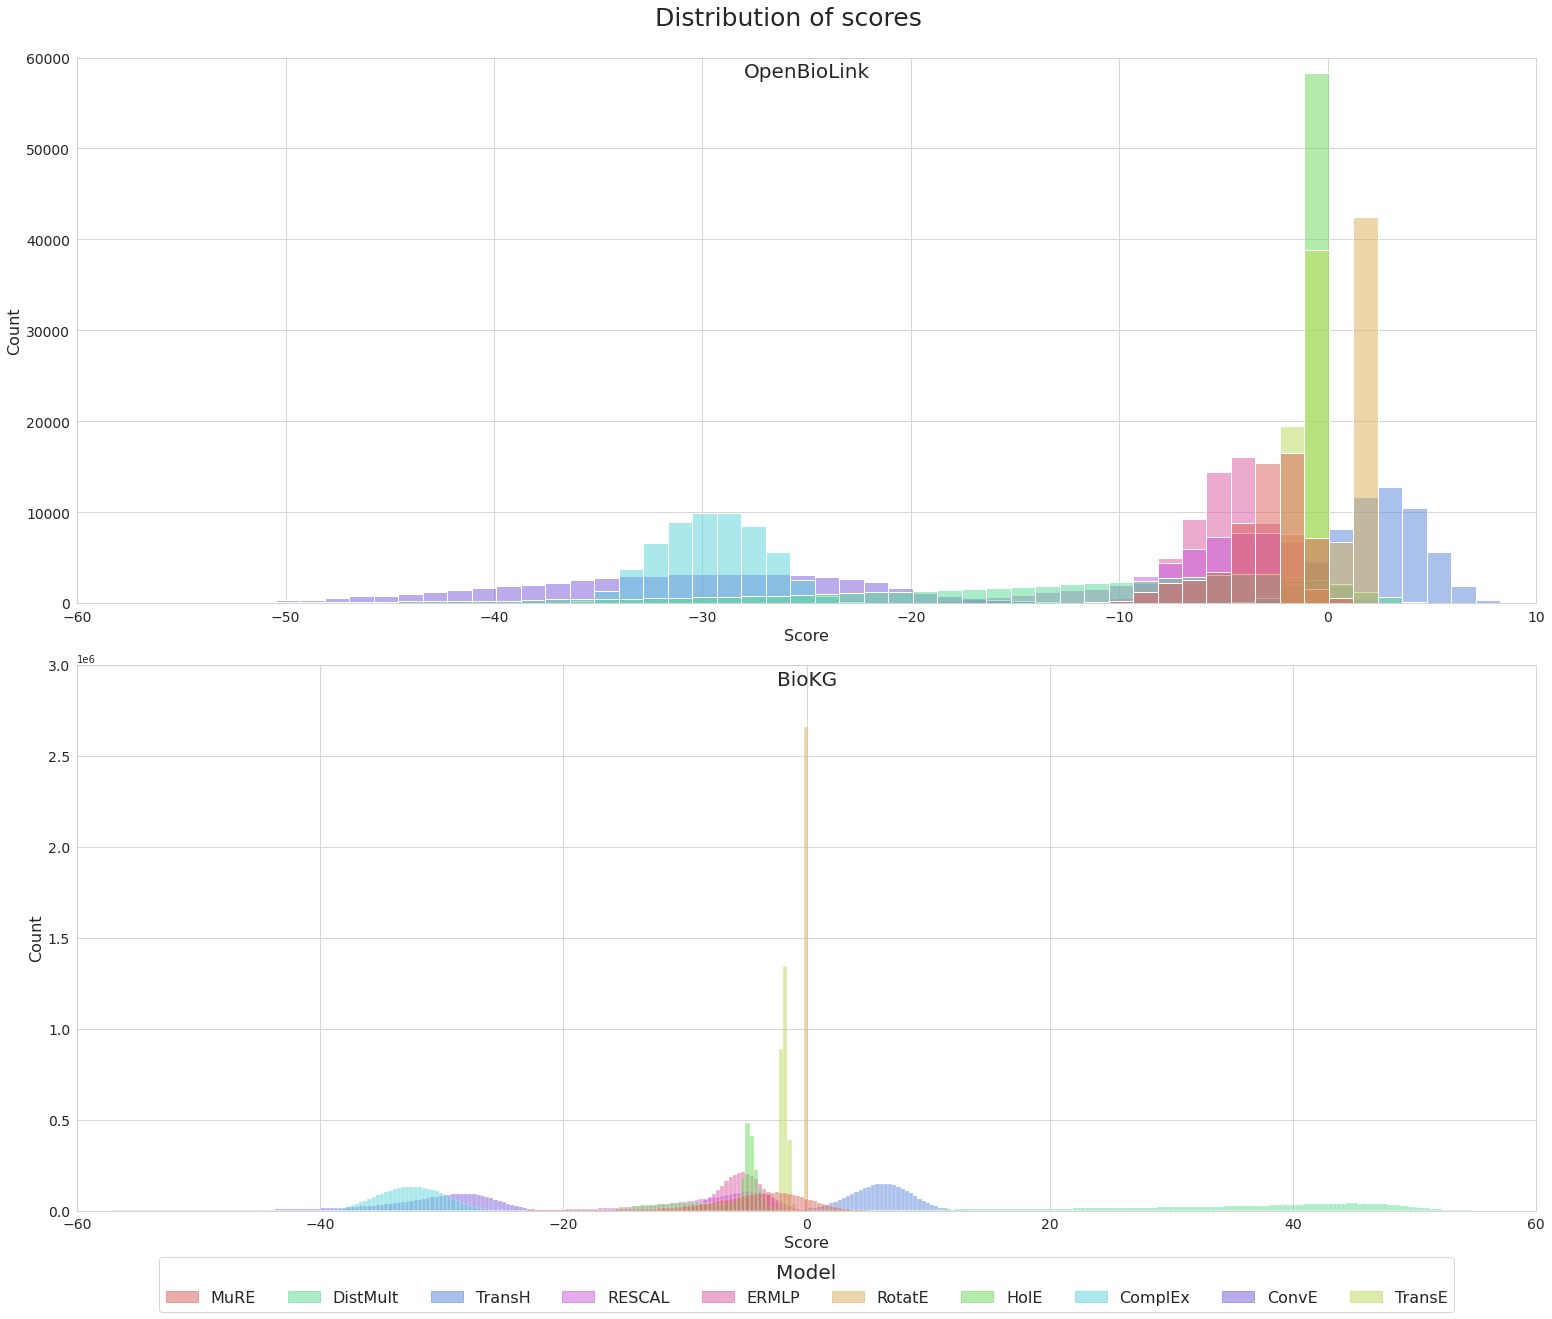

In [6]:
plot_score_distribution(
    df=df,
    title=f'Distribution of scores',
    save_to=f'score_distribution_kgs.png',
    bins=[100, 500],
    xlim=[(-60, 10), (-60, 60)],
    ylim=[(0, 60000), (0, 3000000)],
)

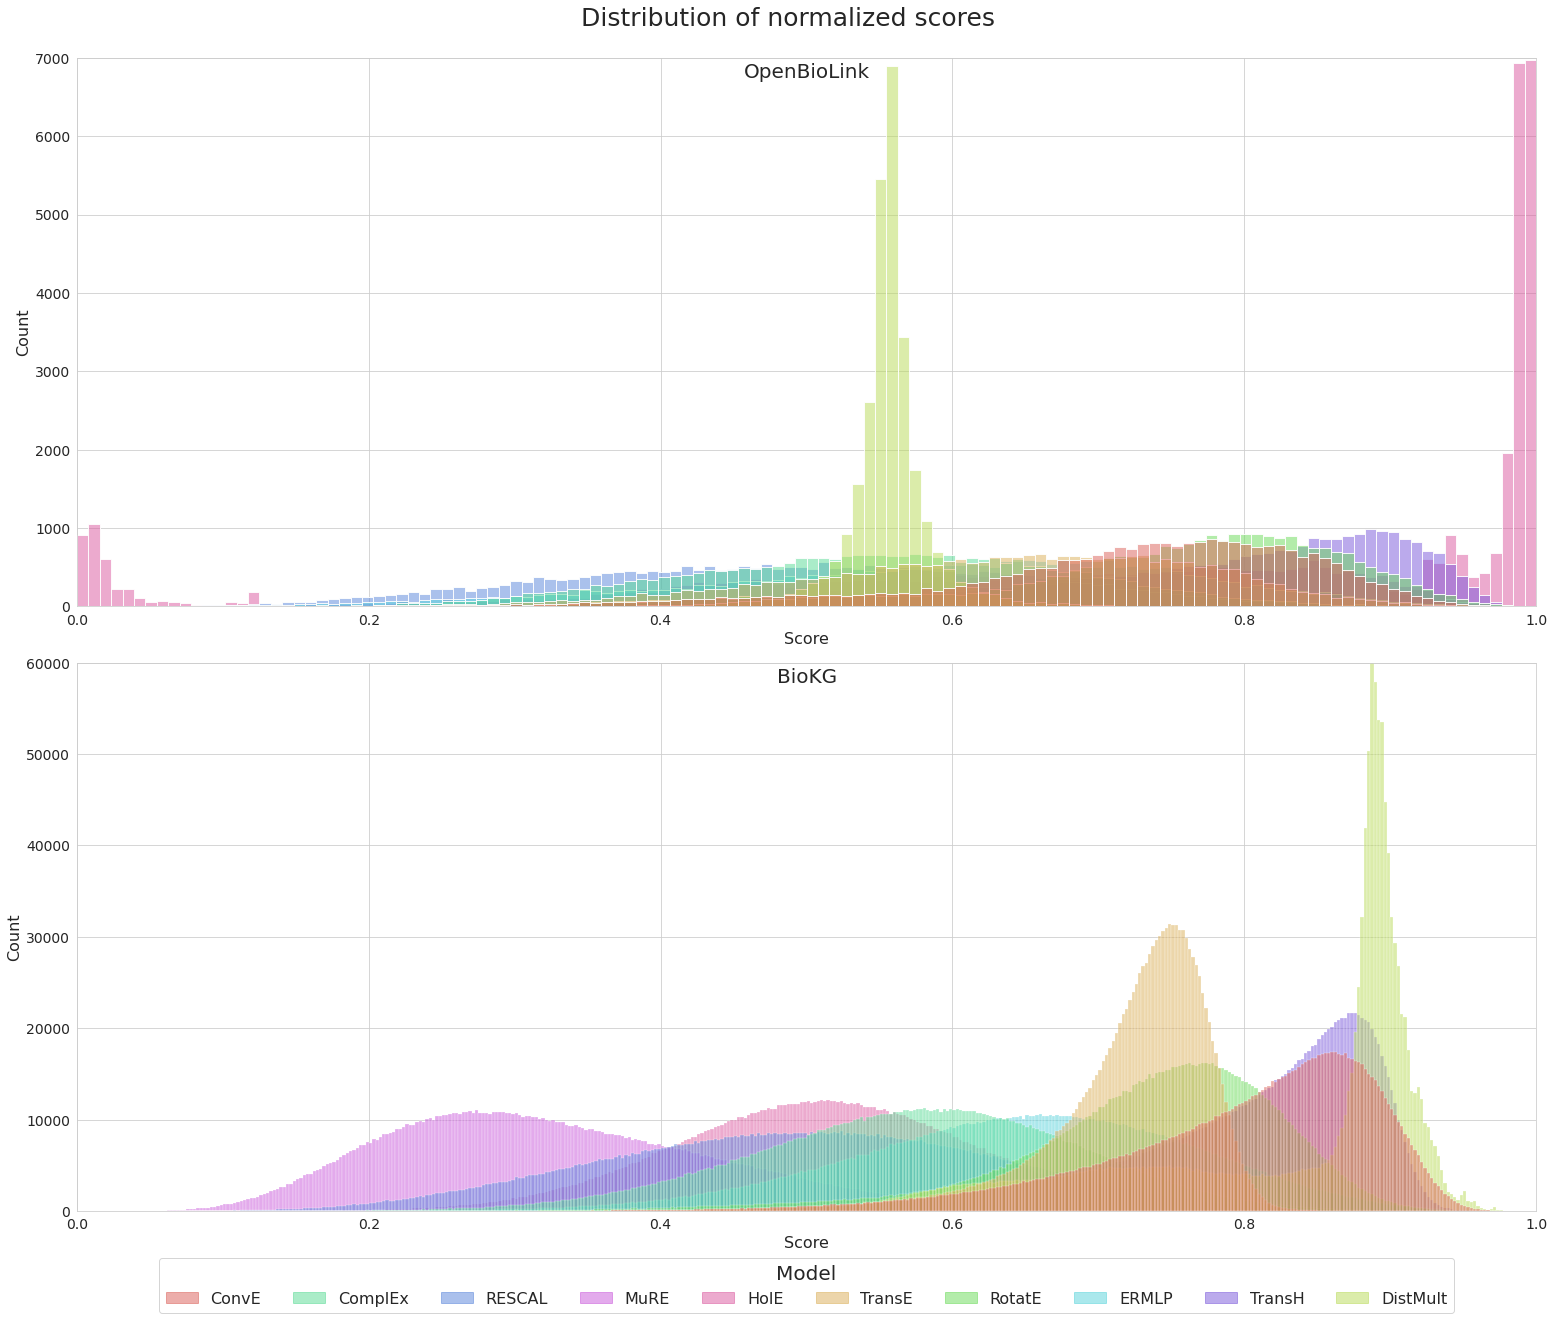

In [7]:
plot_score_distribution(
    df=df_norm,
    title=f'Distribution of normalized scores',
    save_to=f'score_distribution_kgs-normalized.png',
    ylim=[(0,7000), (0, 60000)],
    xlim=[(0,1), (0,1)], 
)

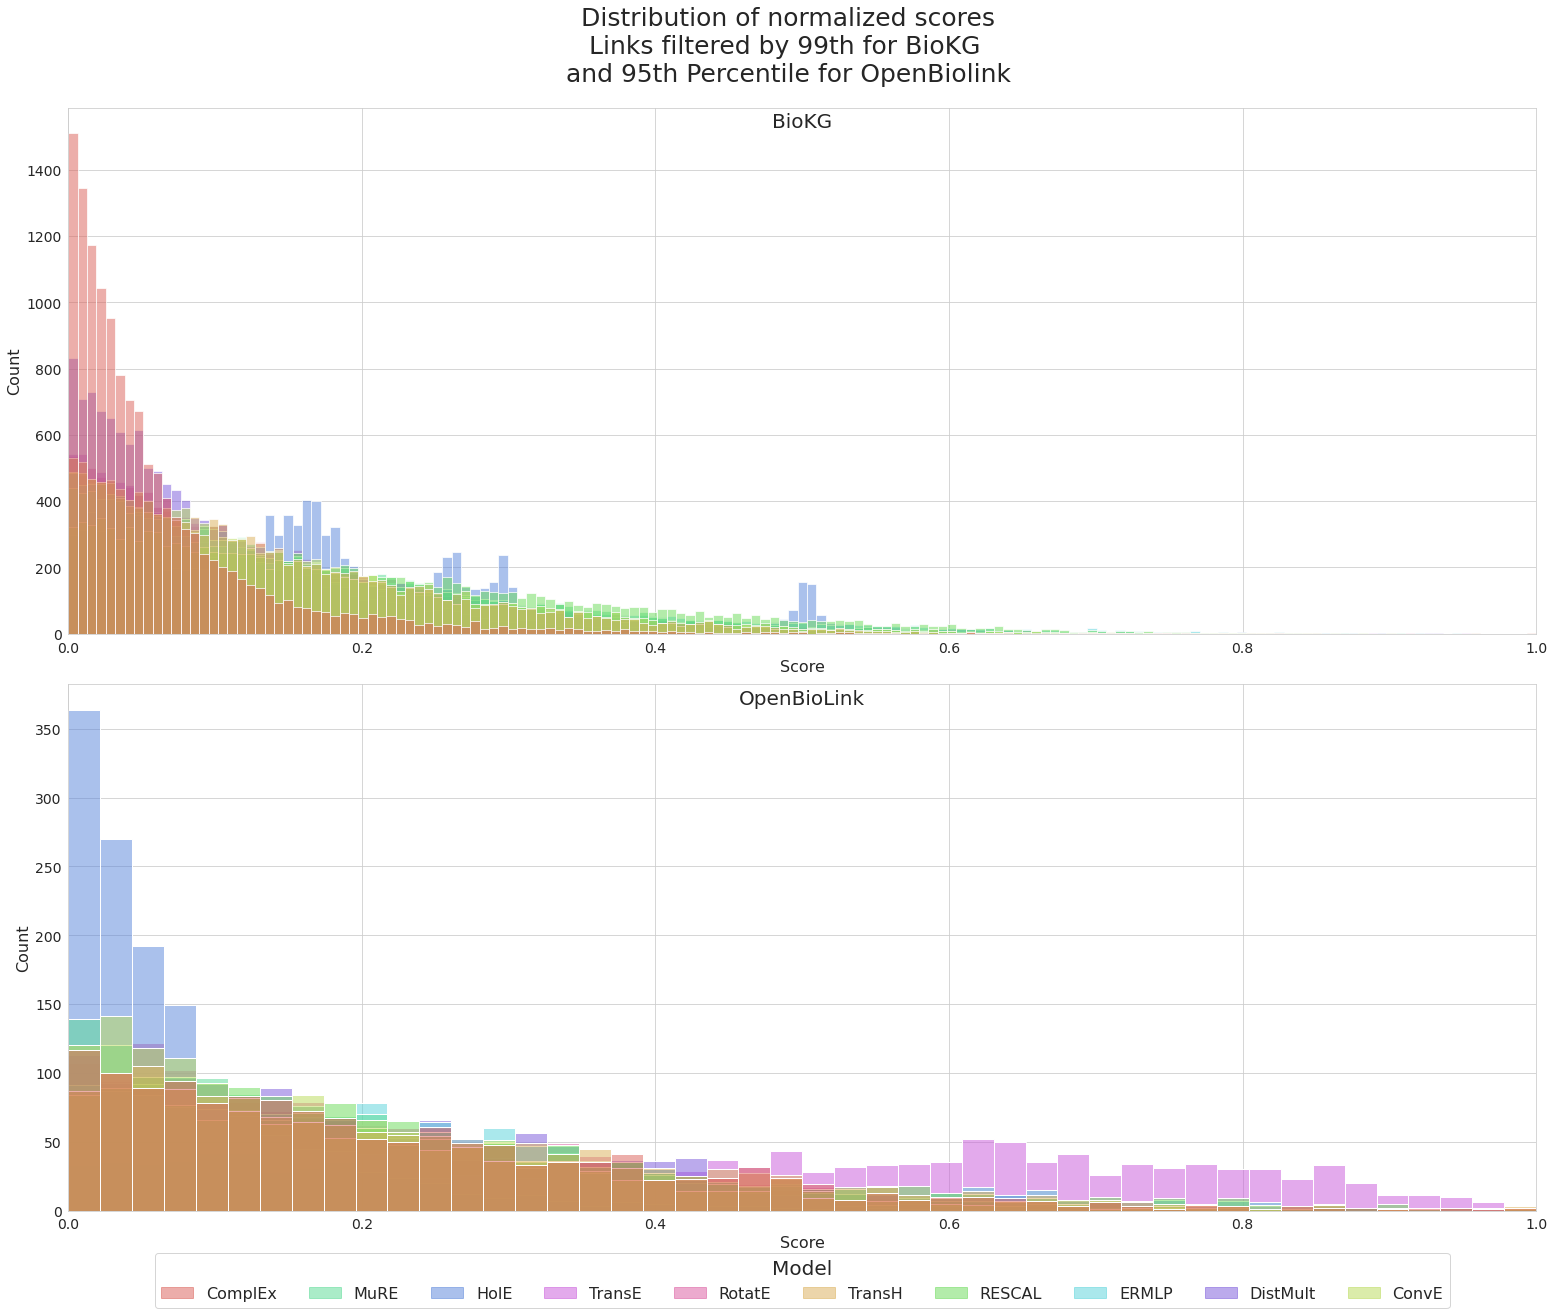

In [8]:
plot_score_distribution(
    df=df_norm_filter,
    title=f'Distribution of normalized scores\nLinks filtered by 99th for BioKG \nand 95th Percentile for OpenBiolink',
    save_to=f'score_distribution_kgs-normalized-filtered.png',
    xlim=[(0,1), (0,1)],
)

In [9]:
def plot_grid_score_distribution(
    df_list,
    bins=None,
    xlim=None,
    title=None,
    figsize=(22,18),
    save_to=None
):

    models = df_list[0].model.unique()
    palette = sns.color_palette('hls', n_colors=len(models))

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
    _bins = 'auto'
    for i, (ax, df) in enumerate(zip(axs.flatten(), df_list)):
        kg = df.kg.unique()[0]
        if bins is not None:
            _bins = bins[i]
        sns.histplot(
            data=df[(df['kg'] == kg) & df['model'].isin(models)],
            x='score',
            hue='model',
            hue_order=models,
            palette=palette,
            ax=ax,
            legend=False,
            bins=_bins,
        )
        ax.set_title(kg2title[kg], y=1.0, pad=-20, fontsize=20)
        if xlim is not None:
            ax.set_xlim(xlim[i])
        
        ax.set_xlim((0,1))
        ax.set_xlabel('Score', fontsize=16)
        ax.set_ylabel('Count', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=14)
    
    
    bars = [r for r in axs.flatten()[-1].get_children() if type(r) == mpatches.Rectangle]
    colors = [c.get_facecolor() for c in bars[:-1]]
    colors = set(colors)
    legend = plt.legend(
        title="Model",
        title_fontsize=20,
        loc='center',
        fancybox=True,
        handles=create_legend(models, colors),
        fontsize=16,
        bbox_to_anchor=(-0.1, -0.2),
        ncol=len(models),
    )
    
    if title is not None:
        fig.suptitle(title, fontsize=25, y=0.92)
        
    plt.subplots_adjust(wspace=0.2, hspace=0.1)

    if save_to is not None:
        plt.savefig(os.path.join(PLOTS_PATH, save_to), dpi=360, bbox_inches='tight')

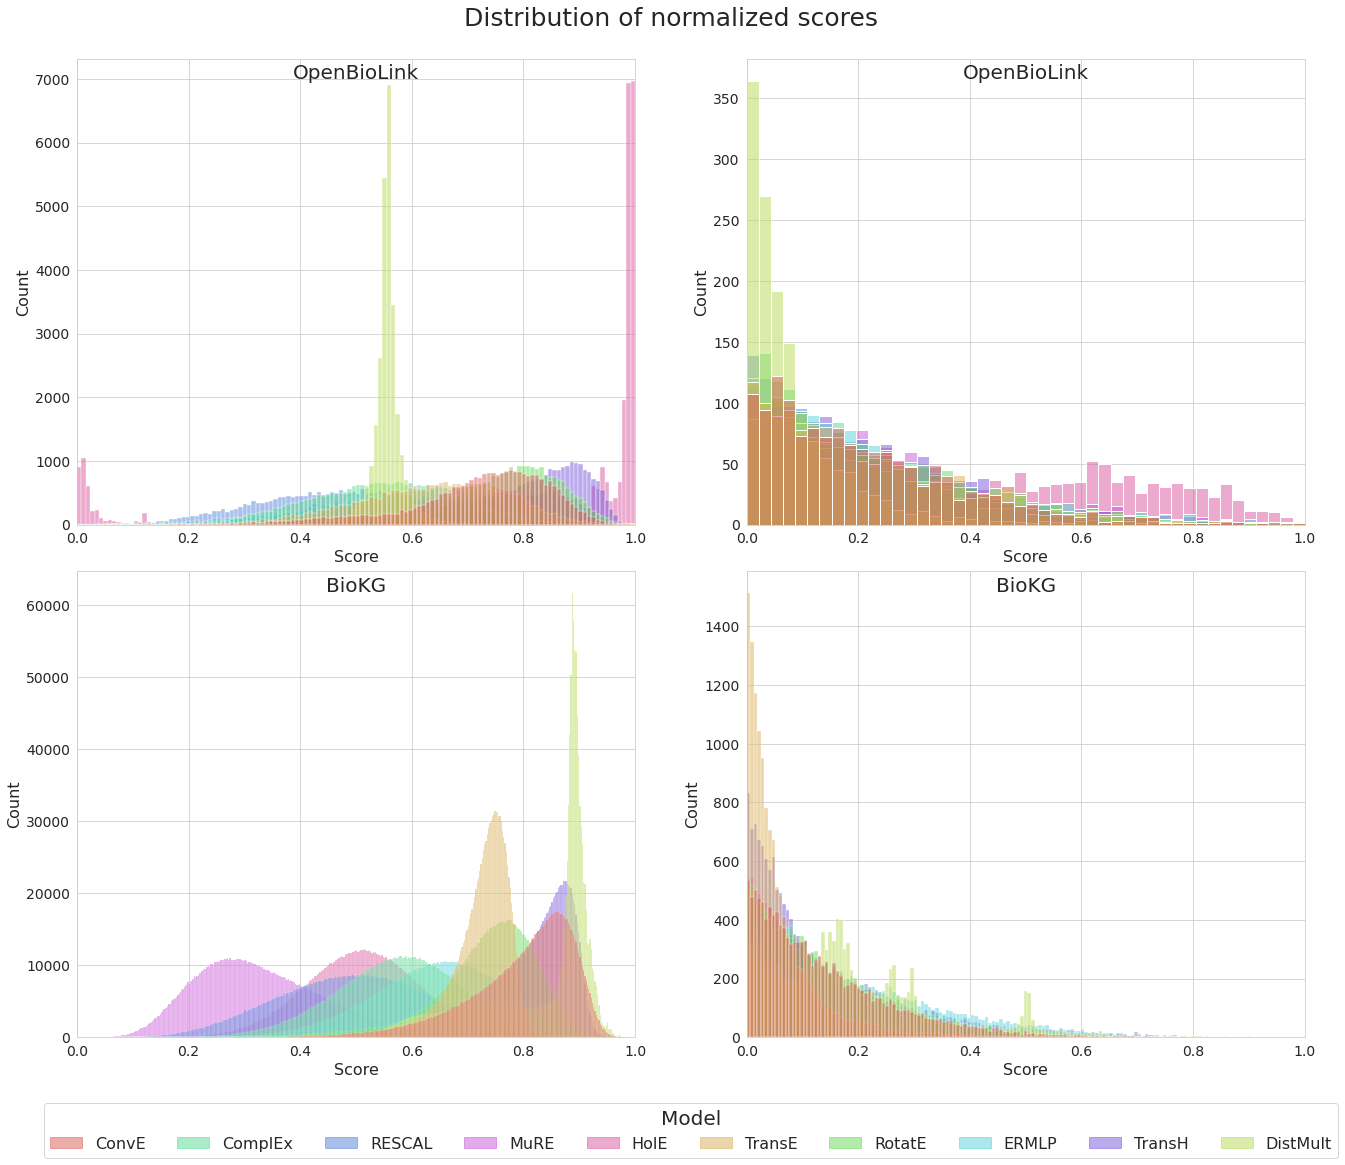

In [10]:
df_open = df_norm[df_norm['kg'] == 'openbiolink']
df_bio = df_norm[df_norm['kg'] == 'biokg']
df_open95 = df_norm_filter[df_norm_filter['kg'] == 'openbiolink']
df_bio99 = df_norm_filter[df_norm_filter['kg'] == 'biokg']

plot_grid_score_distribution(
    df_list=[df_open, df_open95, df_bio, df_bio99],
    title=f'Distribution of normalized scores',
    save_to=f'grid_score_distribution_kgs.png',
)